# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---

## Import Packages

In [1]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [34]:
### Global variables and constants defined here

# constants
SLOPE_TOLERANCE = 0.5                # Used to derieve allowed slope range based on on previous clip slope
INTERCEPT_TOLERANCE = 25             # Used to derieve allowed intecept range based on on previous clip intercept
TOP_Y_FACTOR = 0                     # Factor that decides the top edge of mask
BOTTOM_Y_FACTOR = 1                  # Factor that decides the bottom edge of mask
MASK_BOTTOM_RIGHT_X_FACTOR = 0.8    # Factor that decides the bottom right position of mask
MASK_BOTTOM_LEFT_X_FACTOR = 0.2     # Factor that decides the bottom left position of mask
MASK_TOP_RIGHT_X_FACTOR = 0.8       # Factor that decides the top right position of mask
MASK_TOP_LEFT_X_FACTOR = 0.2        # Factor that decides the top left position of mask

#MASK_BOTTOM_RIGHT_X_FACTOR = 0.975    # Factor that decides the bottom right position of mask
#MASK_BOTTOM_LEFT_X_FACTOR = 0.125     # Factor that decides the bottom left position of mask
#MASK_TOP_RIGHT_X_FACTOR = 0.575       # Factor that decides the top right position of mask
#MASK_TOP_LEFT_X_FACTOR = 0.425        # Factor that decides the top left position of mask

detected_lines = []
reset_lanes = True
cb = np.empty([360,1930,3])
c1 = np.empty([370,640,3])
c2 = np.empty([360,640,3])

class Line():
    def __init__(self):

        self.fresh_lane = None
        self.good_lane = None
        self.continous_bad_lanes = 0
        self.leftx_base = None
        self.rightx_base = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset_m = None
        self.lane_width = None
        self.smooth_leftx_base = None
        self.smooth_rightx_base = None
        self.smooth_left_fit = None
        self.smooth_right_fit = None

print("All global variable definition complete")

All global variable definition complete


## Define support functions

The helper functions needed to identify lanes are defined in this section

In [3]:
### Support Functions

""" The helper functions needed to identify lanes are defined in this section """

def showImg(img):
    plt.imshow(img)
    plt.show()
    return

def showGrayImg(img):
    plt.imshow(img, cmap="gray")
    plt.show()
    return

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

# Define a function that thresholds the S-channel of HLS
def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask_bottom_right_x = img.shape[1] * MASK_BOTTOM_RIGHT_X_FACTOR
    mask_bottom_left_x = img.shape[1] * MASK_BOTTOM_LEFT_X_FACTOR
    mask_top_right_x = img.shape[1] * MASK_TOP_RIGHT_X_FACTOR
    mask_top_left_x = img.shape[1] * MASK_TOP_LEFT_X_FACTOR
    mask_top_y = img.shape[0] * TOP_Y_FACTOR
    mask_bottom_y = img.shape[0] * BOTTOM_Y_FACTOR

    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

### Function to create an image collage

def img_collage(marked_img):
    global c1, c2
    c3 = np.concatenate((c1,c2),0)
    marked_img = cv2.resize(marked_img,(1280, 720))
    c0 = cv2.copyMakeBorder(marked_img,0,10,0,10,cv2.BORDER_CONSTANT, value=[255,255,0])
    ct = np.concatenate((c0,c3),1)
    c = np.concatenate((ct,cb),0)
    c = cv2.resize(c,(1280, 720))
    return c

## Function to extract a warped binary image of the lanes

This function takes in a 3 channel RGB olor image and returns a warped binary image with the lane markings only

In [4]:
### Function to extract a warped binary image of the lanes

""" This function takes in a 3 channel RGB olor image and 
    returns a warped binary image with the lane markings only """

def get_binary_warp(image):

    # Undistort the camera image
    image = undistort(image)
    
    s_chn_img = s_select(image, thresh=(100,255))
    l_chn_img = l_select(image, thresh=(50,255))
    gray_img = grayscale(image)
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
#    combined_img[(s_chn_img == 1) | (sobelx_img == 1)] = 1
#    combined_img[(sobel_mag == 1) & (sobel_mag == 1)] = 1
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
    
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    """
    lines = hough_lines(combined_img4, 2, np.pi/180, 100, 30, 20)
    #creating a blank to draw lines on
    line_image = np.copy(image)*0
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((combined_img4, combined_img4, combined_img4)) 
    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    showImg(combo)
    """
    
    warped_image = cv2.warpPerspective(combined_img4, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    masked_image = region_of_interest(warped_image)
  
    
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))
    plt.show()
    
    
    c4 = cv2.resize(combined_img,(640, 360))
    c4 = np.dstack((c4, c4, c4))*255
    c4 = cv2.copyMakeBorder(c4,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    c5 = cv2.resize(warped_image,None,fx=0.5, fy=0.5)
    c5 = np.dstack((c5, c5, c5))*255
    c5 = cv2.copyMakeBorder(c5,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    c6 = cv2.resize(masked_image,None,fx=0.5, fy=0.5)
    c6 = np.dstack((c6, c6, c6))*255
    c6 = cv2.copyMakeBorder(c6,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
    global cb
    cb = np.concatenate((c4, c5, c6),1)

    return masked_image

## Function to extract the left and right line fits from a given warped binary image of the lanes

This function takes in a warped binary image of the lanes and returns the left and right lane fits

In [5]:
### This function will locate the lane lines from a given binary warped image

def find_fresh_lanes(binary_warped):
    
    print("Inside reset")
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    global c2
    c2 = cv2.resize(out_img,None,fx=0.5, fy=0.5)
    c2 = cv2.copyMakeBorder(c2,0,10,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    showImg(c2)
 
    global reset_lanes
    reset_lanes = False

    return leftx_base, rightx_base, left_lane_inds, right_lane_inds
    

In [15]:
# Perform sanity checks.

def sanity_check_lanes(l):
    
    good_lane = True
    
    while True:

        # Low Pass Filter - Do the left and rigth lanes have enough pixels
        if len(l.leftx) < 20 or len(l.rightx) < 20:
            good_lane = False
            print("@", len(detected_lines),  " > low pass failure : ", len(l.leftx), len(l.rightx) )
            break

        # Is the lane width reasonable (around 3.7 m)
        if not(3 < l.lane_width < 4.2):
            good_lane = False
            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            break

        # Are the lane curvatures reasonable
        if l.left_curverad > 20000 or l.right_curverad > 20000:
            good_lane = False
            print("@", len(detected_lines),  " > curve check failure : ", l.left_curverad, l.right_curverad)
            break

        # Do the left and right lanes have similar curvature
        if abs(l.left_curverad - l.right_curverad) > 10000:
            good_lane = False
            print("@", len(detected_lines),  " > left and right curves similarity failure : ", l.left_curverad, l.right_curverad)
            break
            
        # Are the lanes parallel (co-eff check)
#        if abs(l.left_fit[0] - l.right_fit[0]) > abs(0.75 * l.left_fit[0]):
        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0005:
            good_lane = False
            print("@", len(detected_lines),  " > 2nd order coefficient similarity failure : ", l.left_fit[0], l.right_fit[0])
            break
            
#        if abs(l.left_fit[1] - l.right_fit[1]) > abs(0.75 * l.left_fit[1]):
        if abs(l.left_fit[1] - l.right_fit[1]) > 0.3:
            good_lane = False
            print("@", len(detected_lines),  " > 1st order coefficient similarity failure : ", l.left_fit[1], l.right_fit[1])
            break
        
        if not l.fresh_lane:
            
            # Is the lane offset marginal from prev frame
                if abs(l.center_offset_m - detected_lines[-1].center_offset_m) > 0.5:
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - lane offset variation high : ", 
                          l.center_offset_m, detected_lines[-1].center_offset_m)
                    break

            # Is the left curvature offset reasonable from prev frame
                if abs(l.left_curverad - detected_lines[-1].left_curverad) > abs(3.0 * l.left_curverad):
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - left curve variation high : ", 
                          l.left_curverad, detected_lines[-1].left_curverad)
                    break
            
            # Is the right curvature offset reasonable from prev frame
                if abs(l.right_curverad - detected_lines[-1].right_curverad) > abs(3.0 * l.right_curverad):
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - right curve variation high : ", 
                          l.right_curverad, detected_lines[-1].right_curverad)
                    break

            # Is the co-eff offset reasonable from prev frame
            
        break
            
#    print("lane quality = ", good_lane)
    return good_lane

In [33]:
### Function to extract the left and right line fits from a given warped binary image of the lanes

""" This function takes in a warped binary image of the lanes and 
    returns the left and right lane fits """

def get_line_fits(binary_warped):
    
#    showGrayImg(binary_warped)
    global reset_lanes
#    print('reset status', reset_lanes)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    l = Line()
    
    if reset_lanes :
        leftx_base, rightx_base, left_lane_inds, right_lane_inds = find_fresh_lanes(binary_warped)
        l.fresh_lane = True
    else:
        l.fresh_lane = False
        margin = 100
        left_fit = detected_lines[-1].left_fit
        right_fit = detected_lines[-1].right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        y_base = binary_warped.shape[0]
        leftx_base = left_fit[0]*(y_base**2) + left_fit[1]*y_base + left_fit[2]
        rightx_base = right_fit[0]*(y_base**2) + right_fit[1]*y_base + right_fit[2]
#        print(leftx_base, rightx_base)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    showImg(out_img)

    # Fit a second order polynomial to each lane
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#    print("left fit =" , left_fit)
#    print("right fit =" , right_fit)


    # Calculate radius of curvature
    global baseline_lane_width
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) / 2  # y-value where we want radius of curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension  -->  Manual observation
#    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#    ym_per_pix = 3/7 # meters per pixel in y dimension  -->  Manual observation
    xm_per_pix = 3.7/baseline_lane_width # meters per pixel in x dimension
#    print("baseline = ", baseline_lane_width)
#    print("ym = ", ym_per_pix)
#    print("xm = ", xm_per_pix)
#    print("y_eval = ", y_eval)
    
    left_curverad = calculate_curvature(y_eval, left_fit)
    right_curverad = calculate_curvature(y_eval, right_fit)
#    print("Curvature left = ", left_curverad, "px  right = ", right_curverad, "px")
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Determine lane width and offset
    lane_width = (rightx_base - leftx_base) * xm_per_pix
#    lane_center = int((l.rightx_base + l.leftx_base) / 2)
    lane_center = int(leftx_base + ((rightx_base - leftx_base) / 2))
    img_center = np.int(image.shape[1]/2)
    center_offset_px = img_center - lane_center
#    print(center_offset_px)
    center_offset_m = round((center_offset_px * xm_per_pix), 2)
#    print("Lane width = ", lane_width, "m")
#    print("Lane offset = ", center_offset_m, "m")

    l.leftx_base = leftx_base
    l.rightx_base = rightx_base
    l.leftx = leftx
    l.lefty = lefty
    l.rightx = rightx
    l.righty = righty
    l.left_fit = left_fit
    l.right_fit = right_fit
    l.left_curverad = left_curverad
    l.right_curverad = right_curverad
    l.center_offset_m = center_offset_m
    l.lane_width = lane_width
    
    if len(detected_lines) == 0:
        l.good_lane = True
        l.continous_bad_lanes = 0
    else:
        l.continous_bad_lanes = detected_lines[-1].continous_bad_lanes
        l.good_lane = sanity_check_lanes(l)        

    global c1
    c1 = np.zeros_like(out_img)
    c1 = cv2.resize(c1,None,fx=0.5, fy=0.5)
    c1.fill(255)
    cv2.putText(c1,"Frame Metrics - " + str(len(detected_lines) + 1), (200,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lx_base = " + str(int(leftx_base)), (10,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rx_base = " + str(int(rightx_base)), (10,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"ln_width = " + str(round(lane_width,2)), (10,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit2 = " + str(round(left_fit[2],2)), (10,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit2 = " + str(round(right_fit[2],2)), (10,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit1 = " + str(round(left_fit[1],3)), (10,210), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit1 = " + str(round(right_fit[1],3)), (10,240), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit0 = " + str(round(left_fit[0],6)), (10,270), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit0 = " + str(round(right_fit[0],6)), (10,300), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Fresh Lane = " + str(l.fresh_lane), (300,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Good Lane = " + str(l.good_lane), (300,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Bad Lns = " + str(l.continous_bad_lanes), (300,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Left Curve = " + str(int(l.left_curverad)), (300,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Right Curve = " + str(int(l.right_curverad)), (300,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))


    c1 = cv2.copyMakeBorder(c1,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    print(c1.shape)
#    showImg(c1)

    if l.good_lane:
        l.continous_bad_lanes = 0
        i = 1
        l.smooth_leftx_base = l.smooth_rightx_base = 0
        l.smooth_left_fit = l.smooth_right_fit = [0,0,0]
        for line in detected_lines[::-1]:
            l.smooth_leftx_base += line.leftx_base
            l.smooth_rightx_base += line.rightx_base
            l.smooth_left_fit += line.left_fit
            l.smooth_right_fit += line.right_fit
            if i == 3: 
                l.smooth_leftx_base = l.smooth_leftx_base / i
                l.smooth_rightx_base = l.smooth_rightx_base / i
                l.smooth_left_fit = l.smooth_left_fit / i
                l.smooth_right_fit = l.smooth_right_fit / i
                break 
            i += 1
    else:
        l.continous_bad_lanes += 1
        if l.continous_bad_lanes > 3: reset_lanes = True
        l.leftx_base = detected_lines[-1].leftx_base
        l.rightx_base = detected_lines[-1].rightx_base
        l.leftx = detected_lines[-1].leftx
        l.lefty = detected_lines[-1].lefty
        l.rightx = detected_lines[-1].rightx
        l.righty = detected_lines[-1].righty
        l.left_fit = detected_lines[-1].left_fit
        l.right_fit = detected_lines[-1].right_fit
        l.left_curverad = detected_lines[-1].left_curverad
        l.right_curverad = detected_lines[-1].right_curverad
        l.center_offset_m = detected_lines[-1].center_offset_m
        l.lane_width = detected_lines[-1].lane_width
        l.smooth_leftx_base = detected_lines[-1].smooth_leftx_base
        l.smooth_rightx_base = detected_lines[-1].smooth_rightx_base
        l.smooth_left_fit = detected_lines[-1].smooth_left_fit
        l.smooth_right_fit = detected_lines[-1].smooth_right_fit
    
    detected_lines.append(l)

    return l

Inside reset


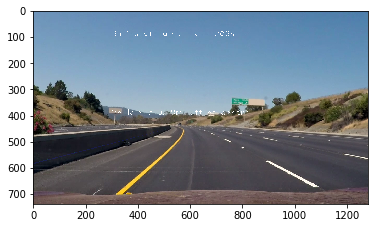

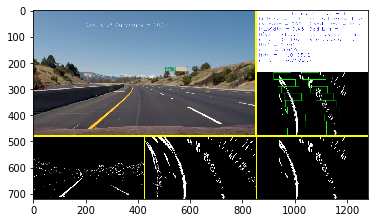

Number of lines detected =  1


In [30]:
reset_lanes = True
images = glob.glob('test_images/t*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
    
print("Number of lines detected = ", len(detected_lines))
    

## Lane Marker Pipeline

This function acts as a pipeline that takes a 3 channel RGB color image as input and returns the same image with lanes marked in it.


In [42]:
### Lane Marker Pipeline
""" This function acts as a pipeline that takes a 3 channel RGB color image as input
    and returns the same image with lanes marked in it """

def lane_marker_pipeline(image):

    binary_warped = get_binary_warp(image)
    l = get_line_fits(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l.smooth_left_fit[0]*ploty**2 + l.smooth_left_fit[1]*ploty + l.smooth_left_fit[2]
    right_fitx = l.smooth_right_fit[0]*ploty**2 + l.smooth_right_fit[1]*ploty + l.smooth_right_fit[2]
#    left_fitx = l.left_fit[0]*ploty**2 + l.left_fit[1]*ploty + l.left_fit[2]
#    right_fitx = l.right_fit[0]*ploty**2 + l.right_fit[1]*ploty + l.right_fit[2]


    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_width = 15
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - line_width, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + line_width, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - line_width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + line_width, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 0.5, window_img, 1.0, 0)

    
    """
    # Draw images
    f = plt.figure(figsize=(30, 18))
   
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
#    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#    showImg(color_warp)
    color_warp = cv2.addWeighted(color_warp, .5, window_img, .5, 0)
#    showImg(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curverad = int((l.left_curverad + l.right_curverad) / 2)
#    print("Curvature =", curverad, "m  left = ", l.left_curverad, "m   right = ", l.right_curverad, "m")
    cv2.putText(marked_img,"Radius of Curvature = " + str(curverad) + "m", (250,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
    if l.center_offset_m > 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m right of centre"
    elif l.center_offset_m < 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m left of centre"
    else:
        offset_txt = "Vehicle is at centre"
    
    cv2.putText(marked_img,offset_txt, (250,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
    
    
    return marked_img

Inside reset


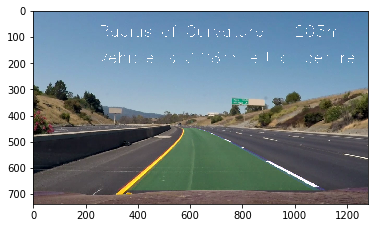

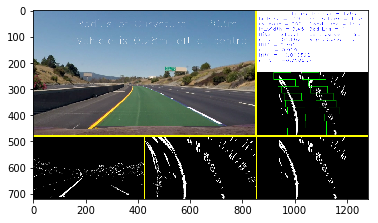

Number of lines detected =  1265


In [43]:
reset_lanes = True
images = glob.glob('test_images/t*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
    
print("Number of lines detected = ", len(detected_lines))
    

## Explore input image characteristics

Read a sample image to find out its shape and type

## Caliberate Camera

This section caliberates the camera by using chessboard images so that images can be distorted

Chess board shape =  (1280, 720)
Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


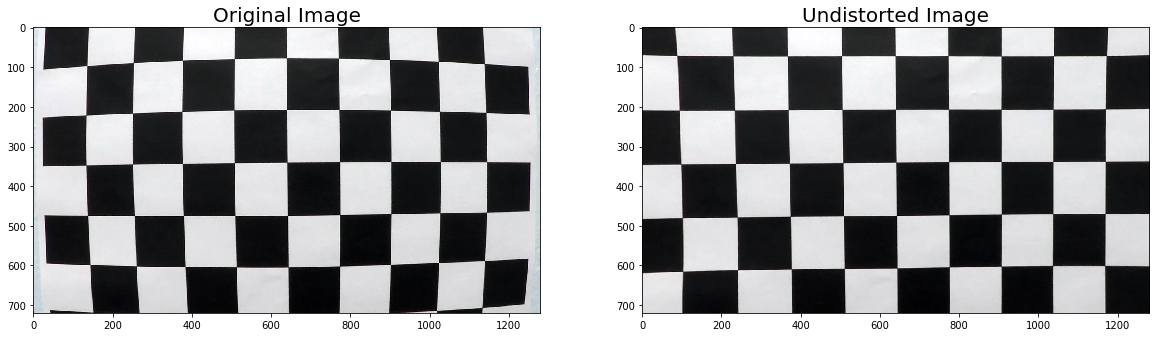

In [9]:
### Caliberate Camera

"""This section caliberates the camera by using chessboard images so that images can be distorted"""

# Chessboard corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

cv2.startWindowThread() 
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = grayscale(img)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
#        cv2.imshow('img', img)
#        cv2.waitKey(500)

#cv2.destroyAllWindows()


# Get chessboard image size
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
print("Chess board shape = ", img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print("Camera caliberated.  mtx = ", mtx, " dist = ", dist)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

## Compute Perspective Transform

This section calculates the Perspective Transform (M) that can be applied to any images later

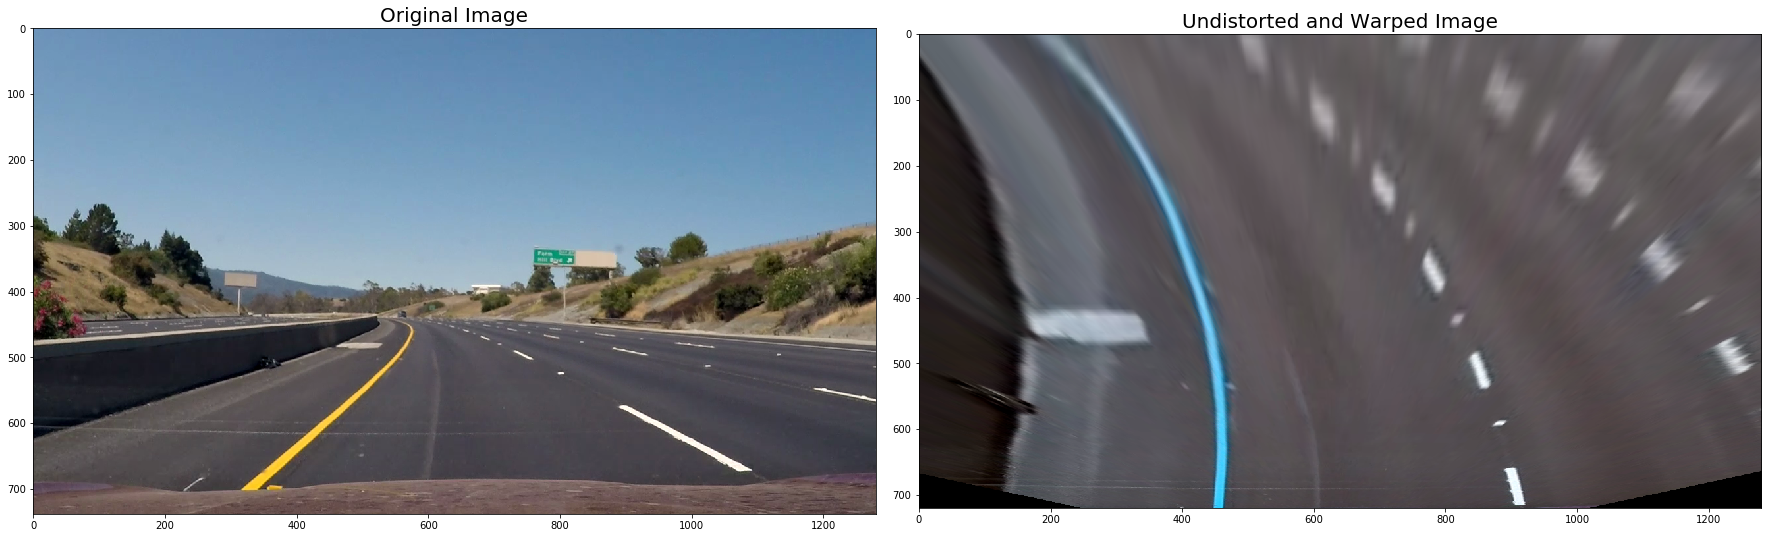

In [10]:
### Compute Perspective Transform (M) and Inverse Transform (Minv)

""" This section calculates the Perspective Transform (M) that can be applied to any images later """

# Read in an image with straight lanes
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Convert to gray scale
gray = grayscale(img)

# Undistorting using mtx and dist from camera caliberation
dst = undistort(img)
   
#Set source and destination image co-ordinates
xoffset = 400 # offset for dst points
yoffset = 10 # offset for dst points

#Define 4 source points src = np.float32([[,],[,],[,],[,]]) from the straight lane image
#src = np.float32([[611,441],[669,441],[998,650],[305,650]])
src = np.float32([[599,448],[682,448],[1010,658],[295,658]])
#src = np.float32([[556,478],[731,478],[998,650],[305,650]])
#src = np.float32([[588,455],[694,455],[1011,660],[295,660]])
#src = np.float32([[588,455],[694,455],[998,650],[305,650]]) # Good co-ordinates


# Define 4 destination points dst = np.float32([[,],[,],[,],[,]]) through trial and error
dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
# Calculate Perspective Transform
perspective_M = cv2.getPerspectiveTransform(src, dst)
    
# Calculate Perspective Inverse Transform
perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    
# Warp the image using the perspective transform M
warped = cv2.warpPerspective(img, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

warped_images = []
images = glob.glob('test_images/t*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    warped_image = cv2.warpPerspective(image, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('img_calib.jpg', warped_image)
    
    # Plot the images for review
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Compute Lane Width

Compute the lane width from a straight lane image in pixels which can be used as a reference to sanity check future images.


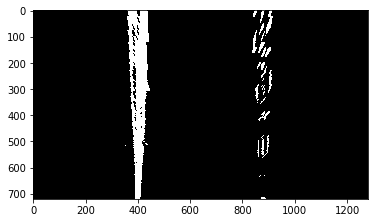

(1280,)
Baseline mid, left, center =  640 398 880
Baeline Lane width in pixels =  482


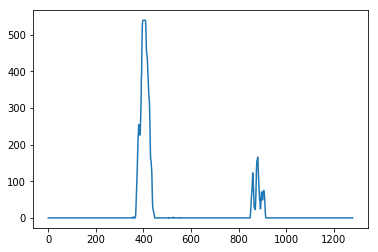

In [11]:
### Determine the lane width using a clean image (straight line image).
### This image will be used for sanity checks on new images

# Read in a baseline image (straight lanes image)
img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

binary_warped = get_binary_warp(img)
showGrayImg(binary_warped)

# Take a histogram of the bottom quarter of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
print(histogram.shape)
plt.plot(histogram)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
baseline_midpoint = np.int(histogram.shape[0]/2)
baseline_leftx_base = np.argmax(histogram[:baseline_midpoint])
baseline_rightx_base = np.argmax(histogram[baseline_midpoint:]) + baseline_midpoint
baseline_lane_width = baseline_rightx_base - baseline_leftx_base
print("Baseline mid, left, center = ", baseline_midpoint, baseline_leftx_base, baseline_rightx_base)
print("Baeline Lane width in pixels = ", baseline_lane_width)

## Validate pipeline on test images

Use test images to validate teh pipeline.


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!



In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = lane_marker_pipeline(image)
    result = img_collage(result)

    return result

Let's try the one with the solid white lane on the right first ...

In [35]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
project_video_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("P2.mp4")
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
print("Number of frames = ", len(detected_lines))

Inside reset
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4




  0%|                                                                                                                                                                                                              | 0/1261 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                     | 1/1261 [00:00<08:47,  2.39it/s]

  0%|▎                                                                                                                                                                                                     | 2/1261 [00:00<08:39,  2.42it/s]

  0%|▍                                                                                                                                                                                                     | 3/1261 [00:01<08:30,  2.46it/s]

  0%|▋                                        

@ 8  > curve check failure :  352.566540819 64124.3932997




  1%|█▎                                                                                                                                                                                                    | 8/1261 [00:03<08:20,  2.51it/s]

  1%|█▍                                                                                                                                                                                                    | 9/1261 [00:03<08:12,  2.54it/s]

  1%|█▌                                                                                                                                                                                                   | 10/1261 [00:03<08:16,  2.52it/s]

  1%|█▋                                                                                                                                                                                                   | 11/1261 [00:04<08:11,  2.54it/s]

  1%|█▊                                       

@ 59  > Continuity check failed - right curve variation high :  274.812493394 3288.19229619




  5%|█████████▏                                                                                                                                                                                           | 59/1261 [00:21<07:08,  2.80it/s]

@ 60  > Continuity check failed - right curve variation high :  217.318583521 3288.19229619




  5%|█████████▎                                                                                                                                                                                           | 60/1261 [00:21<07:12,  2.78it/s]

@ 61  > Continuity check failed - right curve variation high :  261.290046185 3288.19229619




  5%|█████████▌                                                                                                                                                                                           | 61/1261 [00:22<07:16,  2.75it/s]

@ 62  > Continuity check failed - right curve variation high :  395.875328156 3288.19229619




  5%|█████████▋                                                                                                                                                                                           | 62/1261 [00:22<07:16,  2.74it/s]

Inside reset




  5%|█████████▊                                                                                                                                                                                           | 63/1261 [00:22<07:19,  2.73it/s]

  5%|█████████▉                                                                                                                                                                                           | 64/1261 [00:23<07:10,  2.78it/s]

  5%|██████████▏                                                                                                                                                                                          | 65/1261 [00:23<07:08,  2.79it/s]

  5%|██████████▎                                                                                                                                                                                          | 66/1261 [00:23<07:05,  2.81it/s]

  5%|██████████▍                              

@ 71  > 1st order coefficient similarity failure :  0.48612051597 0.813022341915




  6%|███████████                                                                                                                                                                                          | 71/1261 [00:25<06:58,  2.84it/s]

  6%|███████████▏                                                                                                                                                                                         | 72/1261 [00:26<07:01,  2.82it/s]

  6%|███████████▍                                                                                                                                                                                         | 73/1261 [00:26<07:00,  2.83it/s]

  6%|███████████▌                                                                                                                                                                                         | 74/1261 [00:26<06:59,  2.83it/s]

  6%|███████████▋                             

@ 85  > left and right curves similarity failure :  419.165109364 10910.6314361




  7%|█████████████▎                                                                                                                                                                                       | 85/1261 [00:30<07:00,  2.80it/s]

  7%|█████████████▍                                                                                                                                                                                       | 86/1261 [00:31<06:58,  2.81it/s]

@ 87  > Continuity check failed - right curve variation high :  348.080885076 2589.9533863




  7%|█████████████▌                                                                                                                                                                                       | 87/1261 [00:31<06:57,  2.81it/s]

@ 88  > Continuity check failed - right curve variation high :  246.826277875 2589.9533863




  7%|█████████████▋                                                                                                                                                                                       | 88/1261 [00:31<07:04,  2.76it/s]

@ 89  > Continuity check failed - right curve variation high :  282.656633879 2589.9533863




  7%|█████████████▉                                                                                                                                                                                       | 89/1261 [00:32<07:01,  2.78it/s]

@ 90  > Continuity check failed - right curve variation high :  439.710555399 2589.9533863




  7%|██████████████                                                                                                                                                                                       | 90/1261 [00:32<07:08,  2.73it/s]

Inside reset




  7%|██████████████▏                                                                                                                                                                                      | 91/1261 [00:32<07:09,  2.72it/s]

  7%|██████████████▎                                                                                                                                                                                      | 92/1261 [00:33<07:04,  2.76it/s]

  7%|██████████████▌                                                                                                                                                                                      | 93/1261 [00:33<07:01,  2.77it/s]

  7%|██████████████▋                                                                                                                                                                                      | 94/1261 [00:33<06:59,  2.78it/s]

  8%|██████████████▊                          

@ 160  > 1st order coefficient similarity failure :  0.5411696134 0.906421045982




 13%|████████████████████████▊                                                                                                                                                                           | 160/1261 [00:57<06:37,  2.77it/s]

@ 161  > 1st order coefficient similarity failure :  0.526585143687 0.828316376879




 13%|█████████████████████████                                                                                                                                                                           | 161/1261 [00:57<06:37,  2.77it/s]

 13%|█████████████████████████▏                                                                                                                                                                          | 162/1261 [00:57<06:33,  2.79it/s]

 13%|█████████████████████████▎                                                                                                                                                                          | 163/1261 [00:58<06:31,  2.81it/s]

 13%|█████████████████████████▍                                                                                                                                                                          | 164/1261 [00:58<06:29,  2.82it/s]

 13%|█████████████████████████▋               

@ 173  > 1st order coefficient similarity failure :  0.566845011016 0.953505121619




 14%|██████████████████████████▉                                                                                                                                                                         | 173/1261 [01:01<06:25,  2.82it/s]

@ 174  > 1st order coefficient similarity failure :  0.595103998133 0.935008709772




 14%|███████████████████████████                                                                                                                                                                         | 174/1261 [01:02<06:28,  2.80it/s]

 14%|███████████████████████████▏                                                                                                                                                                        | 175/1261 [01:02<06:23,  2.83it/s]

 14%|███████████████████████████▎                                                                                                                                                                        | 176/1261 [01:02<06:24,  2.82it/s]

 14%|███████████████████████████▌                                                                                                                                                                        | 177/1261 [01:03<06:23,  2.83it/s]

 14%|███████████████████████████▋             

@ 190  > 1st order coefficient similarity failure :  0.715605887433 1.03965596515




 15%|█████████████████████████████▌                                                                                                                                                                      | 190/1261 [01:07<06:16,  2.84it/s]

@ 191  > 1st order coefficient similarity failure :  0.726303362854 1.0413597749




 15%|█████████████████████████████▋                                                                                                                                                                      | 191/1261 [01:08<06:26,  2.77it/s]

 15%|█████████████████████████████▊                                                                                                                                                                      | 192/1261 [01:08<06:26,  2.76it/s]

 15%|█████████████████████████████▉                                                                                                                                                                      | 193/1261 [01:08<06:22,  2.79it/s]

 15%|██████████████████████████████▏                                                                                                                                                                     | 194/1261 [01:09<06:16,  2.84it/s]

 15%|██████████████████████████████▎          

@ 235  > 1st order coefficient similarity failure :  0.476411539362 0.796513799484




 19%|████████████████████████████████████▌                                                                                                                                                               | 235/1261 [01:23<06:01,  2.84it/s]

 19%|████████████████████████████████████▋                                                                                                                                                               | 236/1261 [01:24<06:05,  2.81it/s]

 19%|████████████████████████████████████▊                                                                                                                                                               | 237/1261 [01:24<06:04,  2.81it/s]

 19%|████████████████████████████████████▉                                                                                                                                                               | 238/1261 [01:24<06:03,  2.81it/s]

 19%|█████████████████████████████████████▏   

@ 243  > 1st order coefficient similarity failure :  0.550559339021 0.865478770739




 19%|█████████████████████████████████████▊                                                                                                                                                              | 243/1261 [01:26<06:04,  2.79it/s]

@ 244  > 1st order coefficient similarity failure :  0.548041081305 0.84847529635




 19%|█████████████████████████████████████▉                                                                                                                                                              | 244/1261 [01:26<06:02,  2.81it/s]

 19%|██████████████████████████████████████                                                                                                                                                              | 245/1261 [01:27<06:06,  2.78it/s]

 20%|██████████████████████████████████████▏                                                                                                                                                             | 246/1261 [01:27<06:03,  2.79it/s]

 20%|██████████████████████████████████████▍                                                                                                                                                             | 247/1261 [01:27<06:05,  2.77it/s]

 20%|██████████████████████████████████████▌  

@ 311  > Continuity check failed - right curve variation high :  1021.60247402 4870.54883908




 25%|████████████████████████████████████████████████▎                                                                                                                                                   | 311/1261 [01:50<05:41,  2.79it/s]

@ 312  > Continuity check failed - right curve variation high :  774.966814786 4870.54883908




 25%|████████████████████████████████████████████████▍                                                                                                                                                   | 312/1261 [01:51<05:48,  2.72it/s]

@ 313  > Continuity check failed - right curve variation high :  637.56529399 4870.54883908




 25%|████████████████████████████████████████████████▋                                                                                                                                                   | 313/1261 [01:51<05:48,  2.72it/s]

@ 314  > Continuity check failed - right curve variation high :  661.261562142 4870.54883908




 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 314/1261 [01:51<05:50,  2.71it/s]

Inside reset




 25%|████████████████████████████████████████████████▉                                                                                                                                                   | 315/1261 [01:52<05:52,  2.68it/s]

 25%|█████████████████████████████████████████████████                                                                                                                                                   | 316/1261 [01:52<05:49,  2.71it/s]

 25%|█████████████████████████████████████████████████▎                                                                                                                                                  | 317/1261 [01:52<05:46,  2.72it/s]

 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 318/1261 [01:53<05:50,  2.69it/s]

 25%|█████████████████████████████████████████

@ 330  > Continuity check failed - right curve variation high :  618.947234394 11540.2815193




 26%|███████████████████████████████████████████████████▎                                                                                                                                                | 330/1261 [01:57<05:42,  2.72it/s]

@ 331  > Continuity check failed - right curve variation high :  791.201325769 11540.2815193




 26%|███████████████████████████████████████████████████▍                                                                                                                                                | 331/1261 [01:58<05:44,  2.70it/s]

 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 332/1261 [01:58<05:41,  2.72it/s]

@ 333  > curve check failure :  21923.5132423 1480.12914966




 26%|███████████████████████████████████████████████████▊                                                                                                                                                | 333/1261 [01:58<05:40,  2.72it/s]

@ 334  > curve check failure :  151946.943819 1881.14641056




 26%|███████████████████████████████████████████████████▉                                                                                                                                                | 334/1261 [01:59<05:41,  2.72it/s]

@ 335  > curve check failure :  219189.637864 1366.71653616




 27%|████████████████████████████████████████████████████                                                                                                                                                | 335/1261 [01:59<05:40,  2.72it/s]

@ 336  > curve check failure :  21502.3652327 2708.23978893




 27%|████████████████████████████████████████████████████▏                                                                                                                                               | 336/1261 [02:00<05:40,  2.71it/s]

Inside reset
@ 337  > curve check failure :  21009.8113153 9312.55852524




 27%|████████████████████████████████████████████████████▍                                                                                                                                               | 337/1261 [02:00<05:47,  2.66it/s]

Inside reset
@ 338  > curve check failure :  8928.20631964 24941.8600667




 27%|████████████████████████████████████████████████████▌                                                                                                                                               | 338/1261 [02:00<05:49,  2.64it/s]

Inside reset
@ 339  > left and right curves similarity failure :  14930.0176652 1437.18413894




 27%|████████████████████████████████████████████████████▋                                                                                                                                               | 339/1261 [02:01<05:52,  2.62it/s]

Inside reset




 27%|████████████████████████████████████████████████████▊                                                                                                                                               | 340/1261 [02:01<05:50,  2.63it/s]

 27%|█████████████████████████████████████████████████████                                                                                                                                               | 341/1261 [02:01<05:44,  2.67it/s]

 27%|█████████████████████████████████████████████████████▏                                                                                                                                              | 342/1261 [02:02<05:39,  2.71it/s]

 27%|█████████████████████████████████████████████████████▎                                                                                                                                              | 343/1261 [02:02<05:35,  2.74it/s]

 27%|█████████████████████████████████████████

@ 347  > curve check failure :  9143.1975774 24866.1591884




 28%|█████████████████████████████████████████████████████▉                                                                                                                                              | 347/1261 [02:04<05:32,  2.75it/s]

 28%|██████████████████████████████████████████████████████                                                                                                                                              | 348/1261 [02:04<05:29,  2.77it/s]

@ 349  > left and right curves similarity failure :  19987.2428395 2414.34419072




 28%|██████████████████████████████████████████████████████▏                                                                                                                                             | 349/1261 [02:04<05:33,  2.73it/s]

@ 350  > curve check failure :  57670.0234419 13264.2374924




 28%|██████████████████████████████████████████████████████▍                                                                                                                                             | 350/1261 [02:05<05:34,  2.73it/s]

@ 351  > curve check failure :  27337.7074367 1398.92905063




 28%|██████████████████████████████████████████████████████▌                                                                                                                                             | 351/1261 [02:05<05:34,  2.72it/s]

@ 352  > Continuity check failed - right curve variation high :  751.807609757 4033.13927381




 28%|██████████████████████████████████████████████████████▋                                                                                                                                             | 352/1261 [02:05<05:36,  2.70it/s]

Inside reset




 28%|██████████████████████████████████████████████████████▊                                                                                                                                             | 353/1261 [02:06<05:35,  2.70it/s]

 28%|███████████████████████████████████████████████████████                                                                                                                                             | 354/1261 [02:06<05:31,  2.73it/s]

 28%|███████████████████████████████████████████████████████▏                                                                                                                                            | 355/1261 [02:07<05:28,  2.76it/s]

 28%|███████████████████████████████████████████████████████▎                                                                                                                                            | 356/1261 [02:07<05:26,  2.77it/s]

 28%|█████████████████████████████████████████

@ 362  > Continuity check failed - right curve variation high :  1167.53680825 7799.92145501




 29%|████████████████████████████████████████████████████████▎                                                                                                                                           | 362/1261 [02:09<05:22,  2.78it/s]

@ 363  > Continuity check failed - right curve variation high :  1278.72345787 7799.92145501




 29%|████████████████████████████████████████████████████████▍                                                                                                                                           | 363/1261 [02:09<05:26,  2.75it/s]

@ 364  > Continuity check failed - right curve variation high :  1345.78063626 7799.92145501




 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 364/1261 [02:10<05:27,  2.74it/s]

@ 365  > Continuity check failed - right curve variation high :  879.264536096 7799.92145501




 29%|████████████████████████████████████████████████████████▋                                                                                                                                           | 365/1261 [02:10<05:30,  2.71it/s]

Inside reset




 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 366/1261 [02:11<05:31,  2.70it/s]

 29%|█████████████████████████████████████████████████████████                                                                                                                                           | 367/1261 [02:11<05:27,  2.73it/s]

 29%|█████████████████████████████████████████████████████████▏                                                                                                                                          | 368/1261 [02:11<05:23,  2.76it/s]

 29%|█████████████████████████████████████████████████████████▎                                                                                                                                          | 369/1261 [02:12<05:22,  2.77it/s]

 29%|█████████████████████████████████████████

@ 374  > curve check failure :  26743.5272017 1377.46154909




 30%|██████████████████████████████████████████████████████████▏                                                                                                                                         | 374/1261 [02:13<05:20,  2.76it/s]

 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 375/1261 [02:14<05:18,  2.78it/s]

@ 376  > Continuity check failed - right curve variation high :  1219.09702789 7764.07857067




 30%|██████████████████████████████████████████████████████████▍                                                                                                                                         | 376/1261 [02:14<05:19,  2.77it/s]

@ 377  > Continuity check failed - right curve variation high :  950.48067198 7764.07857067




 30%|██████████████████████████████████████████████████████████▌                                                                                                                                         | 377/1261 [02:15<05:24,  2.72it/s]

@ 378  > Continuity check failed - left curve variation high :  1895.12349988 8130.42901173




 30%|██████████████████████████████████████████████████████████▊                                                                                                                                         | 378/1261 [02:15<05:24,  2.72it/s]

@ 379  > Continuity check failed - right curve variation high :  1647.69758861 7764.07857067




 30%|██████████████████████████████████████████████████████████▉                                                                                                                                         | 379/1261 [02:15<05:25,  2.71it/s]

Inside reset




 30%|███████████████████████████████████████████████████████████                                                                                                                                         | 380/1261 [02:16<05:27,  2.69it/s]

 30%|███████████████████████████████████████████████████████████▏                                                                                                                                        | 381/1261 [02:16<05:24,  2.71it/s]

 30%|███████████████████████████████████████████████████████████▍                                                                                                                                        | 382/1261 [02:16<05:17,  2.77it/s]

 30%|███████████████████████████████████████████████████████████▌                                                                                                                                        | 383/1261 [02:17<05:14,  2.79it/s]

 30%|█████████████████████████████████████████

@ 387  > left and right curves similarity failure :  1860.95608226 12064.9503924




 31%|████████████████████████████████████████████████████████████▏                                                                                                                                       | 387/1261 [02:18<05:16,  2.76it/s]

 31%|████████████████████████████████████████████████████████████▎                                                                                                                                       | 388/1261 [02:18<05:14,  2.78it/s]

 31%|████████████████████████████████████████████████████████████▍                                                                                                                                       | 389/1261 [02:19<05:13,  2.78it/s]

 31%|████████████████████████████████████████████████████████████▌                                                                                                                                       | 390/1261 [02:19<05:09,  2.81it/s]

 31%|█████████████████████████████████████████

@ 393  > curve check failure :  44555.6461916 2248.56927104




 31%|█████████████████████████████████████████████████████████████                                                                                                                                       | 393/1261 [02:20<05:14,  2.76it/s]

@ 394  > curve check failure :  94018.861908 2554.14175284




 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                      | 394/1261 [02:21<05:17,  2.73it/s]

 31%|█████████████████████████████████████████████████████████████▍                                                                                                                                      | 395/1261 [02:21<05:11,  2.78it/s]

@ 396  > curve check failure :  144489.581114 2127.51071229




 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                      | 396/1261 [02:21<05:17,  2.72it/s]

 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                      | 397/1261 [02:22<05:14,  2.74it/s]

 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                      | 398/1261 [02:22<05:13,  2.76it/s]

@ 399  > curve check failure :  1762733.18806 1408.89901058




 32%|██████████████████████████████████████████████████████████████                                                                                                                                      | 399/1261 [02:22<05:15,  2.73it/s]

 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                     | 400/1261 [02:23<05:12,  2.76it/s]

@ 401  > curve check failure :  26359.7731176 943.500430378




 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 401/1261 [02:23<05:10,  2.77it/s]

 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                     | 402/1261 [02:24<05:13,  2.74it/s]

@ 403  > left and right curves similarity failure :  16564.017287 725.895722346




 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                     | 403/1261 [02:24<05:17,  2.71it/s]

@ 404  > left and right curves similarity failure :  15072.2995465 607.765547119




 32%|██████████████████████████████████████████████████████████████▊                                                                                                                                     | 404/1261 [02:24<05:17,  2.70it/s]

@ 405  > curve check failure :  76033.3982947 682.528129869




 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                     | 405/1261 [02:25<05:15,  2.72it/s]

@ 406  > curve check failure :  20544.1315343 515.537031671




 32%|███████████████████████████████████████████████████████████████                                                                                                                                     | 406/1261 [02:25<05:19,  2.68it/s]

Inside reset
@ 407  > curve check failure :  37658.150142 749.325023552




 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                    | 407/1261 [02:25<05:22,  2.65it/s]

Inside reset
@ 408  > curve check failure :  19382.1410471 27952.5477872




 32%|███████████████████████████████████████████████████████████████▍                                                                                                                                    | 408/1261 [02:26<05:27,  2.61it/s]

Inside reset
@ 409  > left and right curves similarity failure :  19469.2950029 1371.03426176




 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 409/1261 [02:26<05:28,  2.60it/s]

Inside reset




 33%|███████████████████████████████████████████████████████████████▋                                                                                                                                    | 410/1261 [02:27<05:28,  2.59it/s]

 33%|███████████████████████████████████████████████████████████████▉                                                                                                                                    | 411/1261 [02:27<05:20,  2.65it/s]

 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 412/1261 [02:27<05:14,  2.70it/s]

 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                   | 413/1261 [02:28<05:09,  2.74it/s]

 33%|█████████████████████████████████████████

@ 425  > Continuity check failed - right curve variation high :  1256.27686865 12884.6490578




 34%|██████████████████████████████████████████████████████████████████                                                                                                                                  | 425/1261 [02:32<05:05,  2.74it/s]

@ 426  > left and right curves similarity failure :  12405.3505921 1570.91980054




 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                                 | 426/1261 [02:32<05:06,  2.72it/s]

@ 427  > curve check failure :  67964.237343 1165.81977892




 34%|██████████████████████████████████████████████████████████████████▎                                                                                                                                 | 427/1261 [02:33<05:08,  2.71it/s]

@ 428  > Continuity check failed - right curve variation high :  1471.15366089 12884.6490578




 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                 | 428/1261 [02:33<05:09,  2.69it/s]

Inside reset




 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 429/1261 [02:34<05:08,  2.69it/s]

 34%|██████████████████████████████████████████████████████████████████▊                                                                                                                                 | 430/1261 [02:34<05:07,  2.71it/s]

 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                 | 431/1261 [02:34<05:03,  2.74it/s]

 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                | 432/1261 [02:35<05:00,  2.76it/s]

 34%|█████████████████████████████████████████

@ 437  > Continuity check failed - right curve variation high :  860.670187558 4677.53398839




 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                                | 437/1261 [02:36<04:57,  2.77it/s]

@ 438  > Continuity check failed - right curve variation high :  917.475950691 4677.53398839




 35%|████████████████████████████████████████████████████████████████████                                                                                                                                | 438/1261 [02:37<04:59,  2.75it/s]

@ 439  > Continuity check failed - right curve variation high :  1003.56491089 4677.53398839




 35%|████████████████████████████████████████████████████████████████████▏                                                                                                                               | 439/1261 [02:37<05:01,  2.73it/s]

@ 440  > Continuity check failed - right curve variation high :  628.510294659 4677.53398839




 35%|████████████████████████████████████████████████████████████████████▍                                                                                                                               | 440/1261 [02:37<05:02,  2.71it/s]

Inside reset




 35%|████████████████████████████████████████████████████████████████████▌                                                                                                                               | 441/1261 [02:38<05:01,  2.72it/s]

 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                               | 442/1261 [02:38<04:58,  2.75it/s]

 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                               | 443/1261 [02:39<04:55,  2.77it/s]

 35%|█████████████████████████████████████████████████████████████████████                                                                                                                               | 444/1261 [02:39<04:54,  2.78it/s]

 35%|█████████████████████████████████████████

@ 448  > curve check failure :  48415.3436847 1459.89822886




 36%|█████████████████████████████████████████████████████████████████████▋                                                                                                                              | 448/1261 [02:40<04:54,  2.76it/s]

@ 449  > curve check failure :  67764.1898434 8224.09227699




 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                              | 449/1261 [02:41<04:56,  2.74it/s]

@ 450  > curve check failure :  28235.5227642 6116.8685221




 36%|█████████████████████████████████████████████████████████████████████▉                                                                                                                              | 450/1261 [02:41<04:57,  2.73it/s]

 36%|██████████████████████████████████████████████████████████████████████                                                                                                                              | 451/1261 [02:41<04:54,  2.75it/s]

 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                             | 452/1261 [02:42<04:52,  2.76it/s]

 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                             | 453/1261 [02:42<04:50,  2.78it/s]

 36%|█████████████████████████████████████████

@ 465  > curve check failure :  2407.5563948 22968.6489322




 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 465/1261 [02:46<04:44,  2.79it/s]

 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 466/1261 [02:47<04:43,  2.80it/s]

 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 467/1261 [02:47<04:43,  2.80it/s]

 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 468/1261 [02:48<04:43,  2.80it/s]

@ 469  > curve check failure :  45025.8797106 10650.5615387




 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 469/1261 [02:48<04:46,  2.77it/s]

@ 470  > curve check failure :  31877.8235631 6041.92915672




 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                           | 470/1261 [02:48<04:48,  2.75it/s]

 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 471/1261 [02:49<04:45,  2.77it/s]

 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 472/1261 [02:49<04:43,  2.78it/s]

 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 473/1261 [02:49<04:42,  2.79it/s]

 38%|█████████████████████████████████████████

@ 488  > left and right curves similarity failure :  14178.0127346 2642.27579116




 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 488/1261 [02:55<04:39,  2.76it/s]

@ 489  > curve check failure :  36856.5167392 730.498886201




 39%|████████████████████████████████████████████████████████████████████████████                                                                                                                        | 489/1261 [02:55<04:43,  2.72it/s]

@ 490  > curve check failure :  70562.5441559 713.18238236




 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 490/1261 [02:55<04:44,  2.71it/s]

@ 491  > curve check failure :  58680.6127401 753.948638907




 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 491/1261 [02:56<04:45,  2.70it/s]

Inside reset
@ 492  > curve check failure :  30772.0030809 711.506574624




 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 492/1261 [02:56<04:48,  2.67it/s]

Inside reset
@ 493  > curve check failure :  47917.9199466 1073.10082889




 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 493/1261 [02:57<04:53,  2.62it/s]

Inside reset
@ 494  > curve check failure :  194314.641931 950.207386027




 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 494/1261 [02:57<04:55,  2.60it/s]

Inside reset
@ 495  > curve check failure :  27699.9417194 1322.41983088




 39%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 495/1261 [02:57<04:57,  2.58it/s]

Inside reset
@ 496  > curve check failure :  21984.2179118 2672.57257427




 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                       | 496/1261 [02:58<04:59,  2.55it/s]

Inside reset
@ 497  > curve check failure :  23128.0391316 2532.46112902




 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 497/1261 [02:58<05:00,  2.54it/s]

Inside reset
@ 498  > curve check failure :  23145.0678537 1147.24393183




 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 498/1261 [02:59<05:01,  2.53it/s]

Inside reset




 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 499/1261 [02:59<04:57,  2.56it/s]

 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 500/1261 [02:59<04:49,  2.63it/s]

 40%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 501/1261 [03:00<04:44,  2.67it/s]

 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                      | 502/1261 [03:00<04:38,  2.72it/s]

 40%|█████████████████████████████████████████

@ 507  > curve check failure :  26206.3990035 1200.45343577




 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 507/1261 [03:02<04:37,  2.72it/s]

 40%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 508/1261 [03:02<04:34,  2.75it/s]

 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                     | 509/1261 [03:03<04:28,  2.80it/s]

 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 510/1261 [03:03<04:31,  2.77it/s]

@ 511  > curve check failure :  6714.36569406 24768.7698511




 41%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 511/1261 [03:03<04:33,  2.74it/s]

@ 512  > curve check failure :  28065.595329 2274.6445197




 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 512/1261 [03:04<04:36,  2.71it/s]

@ 513  > curve check failure :  21029.034361 5568.70406574




 41%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 513/1261 [03:04<04:37,  2.69it/s]

 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 514/1261 [03:04<04:34,  2.72it/s]

 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 515/1261 [03:05<04:32,  2.74it/s]

 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 516/1261 [03:05<04:30,  2.75it/s]

 41%|█████████████████████████████████████████

@ 518  > curve check failure :  1867.38306079 26318.5882095




 41%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 518/1261 [03:06<04:33,  2.71it/s]

 41%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 519/1261 [03:06<04:29,  2.75it/s]

@ 520  > Continuity check failed - right curve variation high :  382.618898208 1743.67509043




 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 520/1261 [03:07<04:32,  2.72it/s]

@ 521  > Continuity check failed - left curve variation high :  574.443172132 2539.26798749




 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 521/1261 [03:07<04:33,  2.71it/s]

@ 522  > Continuity check failed - left curve variation high :  608.501009144 2539.26798749




 41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 522/1261 [03:07<04:33,  2.70it/s]

@ 523  > Continuity check failed - left curve variation high :  614.416367584 2539.26798749




 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 523/1261 [03:08<04:34,  2.68it/s]

Inside reset
@ 524  > 2nd order coefficient similarity failure :  0.000108647264755 -0.000425410396822




 42%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 524/1261 [03:08<04:40,  2.62it/s]

Inside reset




 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 525/1261 [03:09<04:41,  2.61it/s]

@ 526  > 1st order coefficient similarity failure :  -0.225398546071 0.211542206354




 42%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 526/1261 [03:09<04:38,  2.64it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 527/1261 [03:09<04:30,  2.71it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 528/1261 [03:10<04:32,  2.69it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 529/1261 [03:10<04:26,  2.74it/s]

 42%|█████████████████████████████████████████

@ 533  > curve check failure :  100218.769473 334.806276283




 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 533/1261 [03:11<04:25,  2.74it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 534/1261 [03:12<04:24,  2.75it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 535/1261 [03:12<04:23,  2.76it/s]

@ 536  > 2nd order coefficient similarity failure :  3.95094659486e-05 0.000567634476124




 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 536/1261 [03:12<04:21,  2.77it/s]

@ 537  > curve check failure :  83809.6042429 490.002855573




 43%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 537/1261 [03:13<04:28,  2.70it/s]

@ 538  > curve check failure :  21341.1920823 340.277049875




 43%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 538/1261 [03:13<04:27,  2.70it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 539/1261 [03:14<04:26,  2.71it/s]

@ 540  > curve check failure :  34911.0245054 901.11571593




 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 540/1261 [03:14<04:26,  2.71it/s]

@ 541  > Continuity check failed - left curve variation high :  1359.32299553 6980.22246824




 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 541/1261 [03:14<04:26,  2.70it/s]

@ 542  > Continuity check failed - left curve variation high :  1277.23552477 6980.22246824




 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 542/1261 [03:15<04:23,  2.73it/s]

@ 543  > Continuity check failed - left curve variation high :  1378.96066526 6980.22246824




 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 543/1261 [03:15<04:28,  2.68it/s]

Inside reset
@ 544  > 1st order coefficient similarity failure :  0.0972350056444 -0.203152126561




 43%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 544/1261 [03:15<04:32,  2.63it/s]

Inside reset
@ 545  > 1st order coefficient similarity failure :  0.100932601274 -0.236364028386




 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 545/1261 [03:16<04:35,  2.60it/s]

Inside reset
@ 546  > 1st order coefficient similarity failure :  0.0683243829876 -0.28109976246




 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 546/1261 [03:16<04:38,  2.57it/s]

Inside reset
@ 547  > 1st order coefficient similarity failure :  0.0945603448057 -0.294656353779




 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 547/1261 [03:17<04:36,  2.58it/s]

Inside reset
@ 548  > 1st order coefficient similarity failure :  0.0626120308081 -0.299749634873




 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 548/1261 [03:17<04:41,  2.54it/s]

Inside reset
@ 549  > 1st order coefficient similarity failure :  0.0738812197225 -0.287169167832




 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 549/1261 [03:17<04:40,  2.54it/s]

Inside reset
@ 550  > 1st order coefficient similarity failure :  0.105902819687 -0.313744298106




 44%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 550/1261 [03:18<04:39,  2.54it/s]

Inside reset
@ 551  > 1st order coefficient similarity failure :  0.0835072089431 -0.311361436729




 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 551/1261 [03:18<04:41,  2.52it/s]

Inside reset
@ 552  > 1st order coefficient similarity failure :  0.100950265938 -0.303697612693




 44%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 552/1261 [03:19<04:42,  2.51it/s]

Inside reset
@ 553  > 1st order coefficient similarity failure :  0.109995286356 -0.219631881481




 44%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 553/1261 [03:19<04:42,  2.51it/s]

Inside reset




 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 554/1261 [03:19<04:38,  2.54it/s]

@ 555  > left and right curves similarity failure :  17792.9437077 473.754570353




 44%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 555/1261 [03:20<04:34,  2.58it/s]

@ 556  > 1st order coefficient similarity failure :  0.279236588915 -0.0691145292436




 44%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 556/1261 [03:20<04:29,  2.61it/s]

@ 557  > 1st order coefficient similarity failure :  0.484630366396 -0.129976460013




 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 557/1261 [03:21<04:28,  2.62it/s]

@ 558  > 1st order coefficient similarity failure :  0.368405447133 -0.120553930938




 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 558/1261 [03:21<04:28,  2.62it/s]

Inside reset




 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 559/1261 [03:21<04:24,  2.65it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 560/1261 [03:22<04:22,  2.67it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 561/1261 [03:22<04:18,  2.71it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 562/1261 [03:22<04:15,  2.74it/s]

 45%|█████████████████████████████████████████

@ 564  > 1st order coefficient similarity failure :  0.359416595508 0.0577551379664




 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 564/1261 [03:23<04:13,  2.75it/s]

@ 565  > 2nd order coefficient similarity failure :  -0.000903509152365 -0.00014737038097




 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 565/1261 [03:24<04:15,  2.72it/s]

@ 566  > 2nd order coefficient similarity failure :  -0.000937262668695 -7.95949378398e-05




 45%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 566/1261 [03:24<04:11,  2.76it/s]

@ 567  > 1st order coefficient similarity failure :  0.382426182333 0.0453494352422




 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 567/1261 [03:24<04:15,  2.71it/s]

Inside reset




 45%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 568/1261 [03:25<04:14,  2.72it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 569/1261 [03:25<04:10,  2.76it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 570/1261 [03:25<04:07,  2.79it/s]

@ 571  > curve check failure :  45425.9879492 1539.09304095




 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 571/1261 [03:26<04:09,  2.76it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 572/1261 [03:26<04:08,  2.77it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 573/1261 [03:26<04:06,  2.80it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 574/1261 [03:27<04:04,  2.81it/s]

@ 575  > curve check failure :  2437.27847437 149760.268236




 46%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 575/1261 [03:27<04:06,  2.79it/s]

@ 576  > 1st order coefficient similarity failure :  0.293430223256 -0.123644417562




 46%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 576/1261 [03:27<04:08,  2.76it/s]

@ 577  > 1st order coefficient similarity failure :  0.16726137108 -0.165955922198




 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 577/1261 [03:28<04:09,  2.74it/s]

@ 578  > 1st order coefficient similarity failure :  0.132572388153 -0.188369995819




 46%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 578/1261 [03:28<04:09,  2.73it/s]

Inside reset
@ 579  > 1st order coefficient similarity failure :  0.153924660791 -0.189222286011




 46%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 579/1261 [03:29<04:14,  2.68it/s]

Inside reset
@ 580  > 1st order coefficient similarity failure :  0.168019080567 -0.189662464292




 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 580/1261 [03:29<04:18,  2.63it/s]

Inside reset
@ 581  > 1st order coefficient similarity failure :  0.188800940891 -0.177751478226




 46%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 581/1261 [03:29<04:20,  2.61it/s]

Inside reset
@ 582  > 1st order coefficient similarity failure :  0.213219645901 -0.183668560646




 46%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 582/1261 [03:30<04:21,  2.60it/s]

Inside reset




 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 583/1261 [03:30<04:14,  2.66it/s]

@ 584  > Continuity check failed - left curve variation high :  475.166530895 3541.78012257




 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 584/1261 [03:31<04:16,  2.64it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 585/1261 [03:31<04:10,  2.70it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 586/1261 [03:31<04:06,  2.74it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 587/1261 [03:32<04:03,  2.77it/s]

 47%|█████████████████████████████████████████

@ 593  > 1st order coefficient similarity failure :  0.272777310465 -0.0584645869116




 47%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 593/1261 [03:34<03:59,  2.79it/s]

@ 594  > 1st order coefficient similarity failure :  0.302337054755 -0.0533730328143




 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 594/1261 [03:34<04:02,  2.75it/s]

@ 595  > 1st order coefficient similarity failure :  0.181300063791 -0.122583485208




 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 595/1261 [03:34<04:04,  2.72it/s]

@ 596  > 2nd order coefficient similarity failure :  -0.000416597797335 9.36450669986e-05




 47%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 596/1261 [03:35<04:05,  2.71it/s]

Inside reset
@ 597  > 1st order coefficient similarity failure :  0.12821682698 -0.190814508133




 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 597/1261 [03:35<04:06,  2.70it/s]

Inside reset




 47%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 598/1261 [03:36<04:08,  2.67it/s]

@ 599  > left and right curves similarity failure :  13462.9517154 538.858887611




 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 599/1261 [03:36<04:07,  2.67it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 600/1261 [03:36<04:03,  2.72it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 601/1261 [03:37<04:01,  2.73it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 602/1261 [03:37<04:00,  2.75it/s]

 48%|█████████████████████████████████████████

@ 617  > 1st order coefficient similarity failure :  -0.688313108577 -0.344090226991




 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 617/1261 [03:42<03:53,  2.76it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 618/1261 [03:43<03:53,  2.76it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 619/1261 [03:43<03:51,  2.77it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 620/1261 [03:44<03:52,  2.76it/s]

 49%|█████████████████████████████████████████

@ 631  > Continuity check failed - right curve variation high :  596.407502438 5334.45286883




 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 631/1261 [03:47<03:46,  2.78it/s]

@ 632  > Continuity check failed - right curve variation high :  688.09301675 5334.45286883




 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 632/1261 [03:48<03:51,  2.72it/s]

@ 633  > Continuity check failed - right curve variation high :  500.679876166 5334.45286883




 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 633/1261 [03:48<03:49,  2.74it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 634/1261 [03:49<03:50,  2.72it/s]

@ 635  > Continuity check failed - right curve variation high :  546.469799026 3466.9558465




 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 635/1261 [03:49<03:50,  2.71it/s]

@ 636  > Continuity check failed - right curve variation high :  393.694595287 3466.9558465




 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 636/1261 [03:49<03:51,  2.70it/s]

@ 637  > Continuity check failed - right curve variation high :  296.993782563 3466.9558465




 51%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 637/1261 [03:50<03:51,  2.70it/s]

@ 638  > Continuity check failed - right curve variation high :  298.638269535 3466.9558465




 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 638/1261 [03:50<03:50,  2.70it/s]

Inside reset




 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 639/1261 [03:50<03:49,  2.71it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 640/1261 [03:51<03:48,  2.71it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 641/1261 [03:51<03:45,  2.75it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 642/1261 [03:52<03:46,  2.74it/s]

 51%|█████████████████████████████████████████

@ 644  > left and right curves similarity failure :  505.014337191 14391.343993




 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 644/1261 [03:52<03:45,  2.73it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 645/1261 [03:53<03:41,  2.78it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 646/1261 [03:53<03:41,  2.78it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 647/1261 [03:53<03:42,  2.76it/s]

 51%|█████████████████████████████████████████

@ 654  > curve check failure :  324.750397964 21814.0921146




 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 654/1261 [03:56<03:40,  2.76it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 655/1261 [03:56<03:38,  2.78it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 656/1261 [03:57<03:37,  2.79it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 657/1261 [03:57<03:33,  2.83it/s]

 52%|█████████████████████████████████████████

@ 731  > 1st order coefficient similarity failure :  -0.570183397215 -0.258933763772




 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 731/1261 [04:23<03:10,  2.79it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 732/1261 [04:24<03:09,  2.79it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 733/1261 [04:24<03:06,  2.83it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 734/1261 [04:24<03:08,  2.80it/s]

 58%|█████████████████████████████████████████

@ 759  > left and right curves similarity failure :  352.166391467 10774.3773872




 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 759/1261 [04:33<03:01,  2.76it/s]

@ 760  > 1st order coefficient similarity failure :  -0.545645653693 -0.238193906405




 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 760/1261 [04:34<03:02,  2.74it/s]

@ 761  > 1st order coefficient similarity failure :  -0.563281776142 -0.23846004817




 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 761/1261 [04:34<03:02,  2.73it/s]

@ 762  > 1st order coefficient similarity failure :  -0.558635558725 -0.196181143093




 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 762/1261 [04:34<03:03,  2.72it/s]

Inside reset
@ 763  > 1st order coefficient similarity failure :  -0.540168596357 -0.177864215021




 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 763/1261 [04:35<03:07,  2.66it/s]

Inside reset
@ 764  > 2nd order coefficient similarity failure :  0.000338352497908 -0.000362117733126




 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 764/1261 [04:35<03:10,  2.61it/s]

Inside reset
@ 765  > 2nd order coefficient similarity failure :  0.000337032395385 -0.000363135906082




 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 765/1261 [04:35<03:10,  2.60it/s]

Inside reset
@ 766  > curve check failure :  326.561526697 72661.1388234




 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 766/1261 [04:36<03:12,  2.57it/s]

Inside reset




 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 767/1261 [04:36<03:08,  2.63it/s]

@ 768  > 1st order coefficient similarity failure :  -0.560699451911 -0.144286457796




 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 768/1261 [04:37<03:07,  2.63it/s]

@ 769  > 1st order coefficient similarity failure :  -0.576257457294 -0.106934827647




 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 769/1261 [04:37<03:03,  2.68it/s]

@ 770  > 1st order coefficient similarity failure :  -0.587512793382 -0.11679725498




 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 770/1261 [04:37<03:06,  2.64it/s]

@ 771  > 1st order coefficient similarity failure :  -0.58268280829 -0.135914080497




 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 771/1261 [04:38<03:04,  2.66it/s]

Inside reset
@ 772  > 1st order coefficient similarity failure :  -0.557930793009 -0.107843810549




 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 772/1261 [04:38<03:06,  2.63it/s]

Inside reset
@ 773  > 1st order coefficient similarity failure :  -0.541069267618 -0.108604414642




 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 773/1261 [04:38<03:07,  2.60it/s]

Inside reset
@ 774  > 1st order coefficient similarity failure :  -0.525792317189 -0.165821049362




 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 774/1261 [04:39<03:09,  2.57it/s]

Inside reset
@ 775  > curve check failure :  372.57966212 449476.076566




 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 775/1261 [04:39<03:10,  2.56it/s]

Inside reset
@ 776  > 1st order coefficient similarity failure :  -0.541425483564 -0.222559164498




 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 776/1261 [04:40<03:11,  2.54it/s]

Inside reset




 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 777/1261 [04:40<03:07,  2.58it/s]

@ 778  > 1st order coefficient similarity failure :  -0.521937831372 -0.157762814312




 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 778/1261 [04:40<03:08,  2.56it/s]

@ 779  > 1st order coefficient similarity failure :  -0.506448800167 -0.189316907249




 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 779/1261 [04:41<03:04,  2.61it/s]

@ 780  > curve check failure :  459.146892804 27862.9091422




 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 780/1261 [04:41<03:02,  2.64it/s]

@ 781  > curve check failure :  489.592961163 23318.0358472




 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 781/1261 [04:42<03:01,  2.64it/s]

Inside reset




 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 782/1261 [04:42<03:01,  2.64it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 783/1261 [04:42<02:57,  2.69it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 784/1261 [04:43<02:53,  2.75it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 785/1261 [04:43<02:53,  2.74it/s]

 62%|█████████████████████████████████████████

@ 793  > left and right curves similarity failure :  643.540706734 14786.1518052




 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 793/1261 [04:46<02:49,  2.77it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 794/1261 [04:46<02:47,  2.79it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 795/1261 [04:47<02:47,  2.79it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 796/1261 [04:47<02:46,  2.80it/s]

 63%|█████████████████████████████████████████

@ 800  > 1st order coefficient similarity failure :  -0.372264679655 -0.053248364039




 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 800/1261 [04:48<02:44,  2.80it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 801/1261 [04:49<02:44,  2.79it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 802/1261 [04:49<02:43,  2.81it/s]

@ 803  > curve check failure :  456.993713407 50380.6480043




 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 803/1261 [04:49<02:44,  2.79it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 804/1261 [04:50<02:43,  2.80it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 805/1261 [04:50<02:41,  2.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 806/1261 [04:51<02:43,  2.79it/s]

 64%|█████████████████████████████████████████

@ 871  > Continuity check failed - right curve variation high :  871.751529179 3721.87597119




 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 871/1261 [05:14<02:21,  2.76it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 872/1261 [05:14<02:21,  2.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 873/1261 [05:14<02:20,  2.77it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 874/1261 [05:15<02:19,  2.77it/s]

 69%|█████████████████████████████████████████

@ 876  > left and right curves similarity failure :  407.40792761 11053.11184




 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 876/1261 [05:16<02:20,  2.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 877/1261 [05:16<02:19,  2.76it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 878/1261 [05:16<02:17,  2.78it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 879/1261 [05:17<02:17,  2.78it/s]

 70%|█████████████████████████████████████████

@ 882  > Continuity check failed - right curve variation high :  419.858560394 5496.7300628




 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 882/1261 [05:18<02:18,  2.74it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 883/1261 [05:18<02:15,  2.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 884/1261 [05:18<02:15,  2.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 885/1261 [05:19<02:14,  2.79it/s]

 70%|█████████████████████████████████████████

@ 888  > curve check failure :  739.937584126 34737.7017742




 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 888/1261 [05:20<02:15,  2.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 889/1261 [05:20<02:14,  2.77it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 890/1261 [05:21<02:13,  2.79it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 891/1261 [05:21<02:12,  2.80it/s]

 71%|█████████████████████████████████████████

@ 895  > Continuity check failed - right curve variation high :  1798.54563465 10482.0645294




 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 895/1261 [05:22<02:11,  2.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 896/1261 [05:23<02:11,  2.78it/s]

@ 897  > left and right curves similarity failure :  803.807540634 13069.023586




 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 897/1261 [05:23<02:10,  2.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 898/1261 [05:23<02:11,  2.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 899/1261 [05:24<02:10,  2.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 900/1261 [05:24<02:08,  2.81it/s]

 71%|█████████████████████████████████████████

@ 949  > Continuity check failed - right curve variation high :  2306.02251715 10076.2479609




 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 949/1261 [05:42<01:54,  2.72it/s]

@ 950  > Continuity check failed - right curve variation high :  1740.36631034 10076.2479609




 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 950/1261 [05:42<01:54,  2.71it/s]

@ 951  > Continuity check failed - right curve variation high :  1593.26740417 10076.2479609




 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 951/1261 [05:43<01:54,  2.71it/s]

@ 952  > curve check failure :  513.48980027 25422.1014589




 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 952/1261 [05:43<01:54,  2.70it/s]

Inside reset




 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 953/1261 [05:43<01:55,  2.66it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 954/1261 [05:44<01:55,  2.66it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 955/1261 [05:44<01:54,  2.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 956/1261 [05:44<01:52,  2.71it/s]

 76%|█████████████████████████████████████████

@ 966  > Continuity check failed - right curve variation high :  485.969619554 3497.24868086




 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 966/1261 [05:48<01:47,  2.75it/s]

@ 967  > 1st order coefficient similarity failure :  -0.425563101176 0.0122293220817




 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 967/1261 [05:48<01:48,  2.71it/s]

@ 968  > 2nd order coefficient similarity failure :  0.000229275142087 -0.000280120362883




 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 968/1261 [05:49<01:48,  2.70it/s]

@ 969  > 1st order coefficient similarity failure :  -0.399261760556 0.0672049898123




 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 969/1261 [05:49<01:48,  2.69it/s]

Inside reset
@ 970  > 1st order coefficient similarity failure :  -0.33548380074 0.0697103057308




 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 970/1261 [05:50<01:50,  2.63it/s]

Inside reset
@ 971  > 1st order coefficient similarity failure :  -0.335161917501 0.0877202440223




 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 971/1261 [05:50<01:52,  2.59it/s]

Inside reset
@ 972  > 1st order coefficient similarity failure :  -0.29351194843 0.125393054969




 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 972/1261 [05:50<01:53,  2.54it/s]

Inside reset
@ 973  > 1st order coefficient similarity failure :  -0.239909273332 0.100250834071




 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 973/1261 [05:51<01:53,  2.54it/s]

Inside reset
@ 974  > curve check failure :  34215.3061649 336.018647135




 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 974/1261 [05:51<01:54,  2.51it/s]

Inside reset
@ 975  > 1st order coefficient similarity failure :  -0.19581382317 0.24096679628




 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 975/1261 [05:52<01:55,  2.49it/s]

Inside reset
@ 976  > 2nd order coefficient similarity failure :  2.68572753506e-05 -0.000929434557161




 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 976/1261 [05:52<01:55,  2.48it/s]

Inside reset
@ 977  > 2nd order coefficient similarity failure :  6.31532619136e-05 -0.00122157177943




 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 977/1261 [05:52<01:55,  2.45it/s]

Inside reset
@ 978  > 1st order coefficient similarity failure :  -0.231345947849 0.178985913525




 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 978/1261 [05:53<01:56,  2.44it/s]

Inside reset




 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 979/1261 [05:53<01:53,  2.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 980/1261 [05:54<01:50,  2.55it/s]

@ 981  > curve check failure :  25755.2701121 466.46653132




 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 981/1261 [05:54<01:48,  2.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 982/1261 [05:54<01:44,  2.67it/s]

@ 983  > Continuity check failed - left curve variation high :  633.456258191 9239.54558686




 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 983/1261 [05:55<01:45,  2.65it/s]

@ 984  > Continuity check failed - left curve variation high :  754.359135416 9239.54558686




 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 984/1261 [05:55<01:43,  2.69it/s]

@ 985  > Continuity check failed - left curve variation high :  681.966081081 9239.54558686




 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 985/1261 [05:55<01:44,  2.64it/s]

@ 986  > Continuity check failed - left curve variation high :  748.479613797 9239.54558686




 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 986/1261 [05:56<01:43,  2.66it/s]

Inside reset




 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 987/1261 [05:56<01:43,  2.65it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 988/1261 [05:57<01:41,  2.70it/s]

@ 989  > 1st order coefficient similarity failure :  -0.144934836899 -0.598374336229




 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 989/1261 [05:57<01:41,  2.68it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 990/1261 [05:57<01:38,  2.74it/s]

@ 991  > 1st order coefficient similarity failure :  -0.227419159482 -0.72003618453




 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 991/1261 [05:58<01:40,  2.69it/s]

@ 992  > 1st order coefficient similarity failure :  -0.243496337656 -0.732990076686




 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 992/1261 [05:58<01:39,  2.70it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 993/1261 [05:58<01:39,  2.70it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 994/1261 [05:59<01:39,  2.69it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 995/1261 [05:59<01:37,  2.72it/s]

 79%|█████████████████████████████████████████

@ 1002  > curve check failure :  44606.8387371 555.638487749




 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1002/1261 [06:02<01:34,  2.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1003/1261 [06:02<01:33,  2.75it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1004/1261 [06:02<01:32,  2.77it/s]

@ 1005  > 1st order coefficient similarity failure :  0.0777132055545 -0.281366931528




 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1005/1261 [06:03<01:33,  2.74it/s]

@ 1006  > 2nd order coefficient similarity failure :  6.21435210054e-05 0.000662051883123




 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1006/1261 [06:03<01:34,  2.71it/s]

@ 1007  > 2nd order coefficient similarity failure :  0.000153019608566 0.000662223199732




 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1007/1261 [06:04<01:34,  2.70it/s]

@ 1008  > 2nd order coefficient similarity failure :  -0.000454289659307 0.000233551353882




 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1008/1261 [06:04<01:33,  2.69it/s]

Inside reset




 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1009/1261 [06:04<01:34,  2.68it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1010/1261 [06:05<01:32,  2.71it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1011/1261 [06:05<01:31,  2.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1012/1261 [06:05<01:30,  2.75it/s]

 80%|█████████████████████████████████████████

@ 1016  > 1st order coefficient similarity failure :  -0.194308734779 -0.609005695147




 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1016/1261 [06:07<01:28,  2.76it/s]

@ 1017  > 1st order coefficient similarity failure :  -0.147399357652 -0.654831603168




 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1017/1261 [06:07<01:28,  2.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1018/1261 [06:08<01:28,  2.75it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1019/1261 [06:08<01:27,  2.75it/s]

@ 1020  > left and right curves similarity failure :  670.852468947 15394.8442209




 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1020/1261 [06:08<01:28,  2.73it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1021/1261 [06:09<01:27,  2.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1022/1261 [06:09<01:26,  2.77it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1023/1261 [06:09<01:25,  2.78it/s]

 81%|█████████████████████████████████████████

@ 1026  > Continuity check failed - right curve variation high :  490.389672459 2862.81889327




 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1026/1261 [06:10<01:24,  2.76it/s]

@ 1027  > Continuity check failed - right curve variation high :  649.826948765 2862.81889327




 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1027/1261 [06:11<01:25,  2.74it/s]

@ 1028  > Continuity check failed - right curve variation high :  646.769225317 2862.81889327




 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1028/1261 [06:11<01:25,  2.71it/s]

@ 1029  > Continuity check failed - right curve variation high :  417.01491182 2862.81889327




 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1029/1261 [06:12<01:25,  2.70it/s]

Inside reset




 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1030/1261 [06:12<01:25,  2.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1031/1261 [06:12<01:24,  2.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1032/1261 [06:13<01:23,  2.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1033/1261 [06:13<01:22,  2.76it/s]

 82%|█████████████████████████████████████████

@ 1078  > left and right curves similarity failure :  555.420174199 10682.3220211




 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1078/1261 [06:29<01:06,  2.74it/s]

@ 1079  > left and right curves similarity failure :  586.738018769 13554.8389868




 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1079/1261 [06:29<01:06,  2.72it/s]

@ 1080  > curve check failure :  579.10523463 42797.4798428




 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1080/1261 [06:30<01:06,  2.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1081/1261 [06:30<01:05,  2.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1082/1261 [06:31<01:05,  2.74it/s]

@ 1083  > Continuity check failed - right curve variation high :  502.063053776 3286.68054548




 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1083/1261 [06:31<01:05,  2.71it/s]

@ 1084  > 1st order coefficient similarity failure :  -0.317221138615 0.0349442061495




 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1084/1261 [06:31<01:05,  2.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1085/1261 [06:32<01:04,  2.72it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1086/1261 [06:32<01:04,  2.73it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1087/1261 [06:32<01:03,  2.76it/s]

 86%|█████████████████████████████████████████

@ 1094  > curve check failure :  1284.24374507 92736.7614288




 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1094/1261 [06:35<01:06,  2.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1095/1261 [06:36<01:07,  2.47it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1096/1261 [06:36<01:05,  2.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1097/1261 [06:36<01:04,  2.55it/s]

@ 1098  > Continuity check failed - right curve variation high :  1326.37569204 9635.82169655




 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1098/1261 [06:37<01:04,  2.51it/s]

@ 1099  > Continuity check failed - right curve variation high :  800.953121147 9635.82169655




 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1099/1261 [06:37<01:06,  2.44it/s]

@ 1100  > Continuity check failed - right curve variation high :  1035.18414698 9635.82169655




 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1100/1261 [06:37<01:04,  2.49it/s]

@ 1101  > Continuity check failed - right curve variation high :  1841.0025361 9635.82169655




 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1101/1261 [06:38<01:03,  2.52it/s]

Inside reset




 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1102/1261 [06:38<01:02,  2.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1103/1261 [06:39<01:01,  2.57it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1104/1261 [06:39<01:00,  2.61it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1105/1261 [06:39<00:58,  2.68it/s]

@ 1106  > left and right curves similarity failure :  875.127079458 11434.4609536




 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1106/1261 [06:40<00:57,  2.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1107/1261 [06:40<00:57,  2.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1108/1261 [06:40<00:56,  2.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1109/1261 [06:41<00:57,  2.65it/s]

 88%|█████████████████████████████████████████

@ 1127  > curve check failure :  548.070107149 103924.197357




 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1127/1261 [06:48<00:49,  2.70it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1128/1261 [06:48<00:48,  2.74it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1129/1261 [06:48<00:48,  2.73it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1130/1261 [06:49<00:47,  2.74it/s]

 90%|█████████████████████████████████████████

@ 1132  > left and right curves similarity failure :  685.29444433 17181.5039874




 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1132/1261 [06:49<00:46,  2.75it/s]

@ 1133  > left and right curves similarity failure :  778.644132189 16546.1515968




 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1133/1261 [06:50<00:47,  2.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1134/1261 [06:50<00:46,  2.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1135/1261 [06:51<00:45,  2.74it/s]

@ 1136  > curve check failure :  899.051006687 53322.674227




 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1136/1261 [06:51<00:45,  2.76it/s]

@ 1137  > Continuity check failed - right curve variation high :  1026.57357213 4527.6660853




 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1137/1261 [06:51<00:45,  2.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1138/1261 [06:52<00:45,  2.71it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1139/1261 [06:52<00:44,  2.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1140/1261 [06:52<00:44,  2.73it/s]

 90%|█████████████████████████████████████████

@ 1184  > left and right curves similarity failure :  614.722669574 12734.0726609




 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1184/1261 [07:08<00:28,  2.69it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1185/1261 [07:09<00:28,  2.71it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1186/1261 [07:09<00:27,  2.73it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1187/1261 [07:09<00:26,  2.76it/s]

@ 1188  > Continuity check failed - right curve variation high :  586.140460623 3263.67883858




 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1188/1261 [07:10<00:26,  2.75it/s]

@ 1189  > Continuity check failed - right curve variation high :  534.168305983 3263.67883858




 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1189/1261 [07:10<00:26,  2.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1190/1261 [07:11<00:26,  2.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1191/1261 [07:11<00:25,  2.74it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1192/1261 [07:11<00:24,  2.76it/s]

 95%|█████████████████████████████████████████

@ 1208  > 1st order coefficient similarity failure :  -0.433592188307 -0.0706685145896




 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1208/1261 [07:17<00:19,  2.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1209/1261 [07:17<00:18,  2.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1210/1261 [07:18<00:18,  2.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1211/1261 [07:18<00:18,  2.78it/s]

 96%|█████████████████████████████████████████

@ 1219  > Continuity check failed - right curve variation high :  815.127575433 3843.44369626




 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1219/1261 [07:21<00:15,  2.75it/s]

@ 1220  > 2nd order coefficient similarity failure :  0.00017326990704 -0.000408647450564




 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1220/1261 [07:21<00:15,  2.73it/s]

@ 1221  > 2nd order coefficient similarity failure :  0.000173015906502 -0.000354319181056




 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1221/1261 [07:22<00:14,  2.72it/s]

@ 1222  > 1st order coefficient similarity failure :  -0.36440478663 -0.00706128555677




 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1222/1261 [07:22<00:14,  2.70it/s]

Inside reset




 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1223/1261 [07:22<00:14,  2.66it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1224/1261 [07:23<00:13,  2.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1225/1261 [07:23<00:13,  2.73it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1226/1261 [07:24<00:12,  2.74it/s]

 97%|█████████████████████████████████████████

@ 1257  > Continuity check failed - right curve variation high :  712.483929853 3650.41690847




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1257/1261 [07:35<00:01,  2.70it/s]

@ 1258  > Continuity check failed - right curve variation high :  831.255043306 3650.41690847




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1258/1261 [07:35<00:01,  2.69it/s]

@ 1259  > curve check failure :  29263.2356284 1005.17295661




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1259/1261 [07:35<00:00,  2.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [07:36<00:00,  2.70it/s]



[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 7min 37s
Number of frames =  1261


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

## Challenge Video

Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Harder Challenge Video

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
prev_clip_data = [0, 0, 0, 0]
bottom_y = 0
harder_challenge_output = 'harder_challenge_video_output.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
harder_challenge_clip = clip2.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

## HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This section iterates through the line co-ordinates returned by Hough transform and
    calculates the average slope (m) and intercept (b) for left lane and right lane seperately.
    Positive slope is considered as right lane and negative slope is considered as left lane.
    
    The following filters are applied :
        1. Lines with slope^2 outside the range of 0.1 and 100 are filtered out as horizontal lines
        2. Lines with slope < 0 (left lane) but lying to the right of center are filtered
        3. Lines with slope > 0 (right lane) but lying to the left of center are filtered
        4. Lines with slope & intercept beyond the allowed variance are filtered.

    The mean of slope and intercept of valid left side lines is calculated as the left lane slope & intecept.
    The mean of slope and intercept of valid right side lines is calculated as the left lane slope & intecept.

    The left and right lanes are extrapolated by determining top and bottom x values using y = mx + b
    for y = top and bottom edge of mask
    
    The extrapolated lines are then drawn to produce the image.
    """

    global prev_clip_data                    # Array that holds the slope & intercept of previous clip
    global bottom_y                          # Variable that holds the bottom most y value

    prev_left_slope = prev_clip_data[0]      # Variable that holds the slope of left lane from previous clip
    prev_left_intercept = prev_clip_data[1]  # Variable that holds the intercept of left lane from previous clip
    prev_right_slope = prev_clip_data[2]     # Variable that holds the slope of right lane from previous clip
    prev_right_intercept = prev_clip_data[3] # Variable that holds the intercept of right lane from previous clip

    left_lane_slope_accumulator = 0.0        # Variable used to accumulate left lane slope to calculate mean
    left_lane_intercept_accumulator = 0.0    # Variable used to accumulate left lane intercept to calculate mean
    left_lane_line_counter = 0               # Variable used to count the number of valid left lanes
    left_lane_intercept_average = 0.0        # Variable used to hold the left lane intercept average
    right_lane_slope_accumulator = 0.0       # Variable used to accumulate right lane slope to calculate mean       
    right_lane_intercept_accumulator = 0.0   # Variable used to accumulate right lane intercept to calculate mean
    right_lane_line_counter = 0              # Variable used to count the number of valid right lanes
    right_lane_slope_average = 0.0           # Variable used to hold the right lane intercept average
    right_lane_intercept_average = 0.0       # Variable used to hold the right lane intercept average

    top_y = int(img.shape[0] * TOP_Y_FACTOR) # Calculates the top edge of mask to be used in extrapolation

    if prev_left_slope == 0:                 # Identifies the very first clip and uses logic without prev clip reference
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)   # Calculate slope & intercept
                if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
#                    cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=2)
                    if slope < 0:                                      # Identifies lane position as left or right
                        left_lane_slope_accumulator += slope
                        left_lane_intercept_accumulator += intercept
                        left_lane_line_counter += 1
                    else:
                        right_lane_slope_accumulator += slope
                        right_lane_intercept_accumulator += intercept
                        right_lane_line_counter += 1
                else:
#                    print ('ignoring line ', line, ' as outlier ', slope, intercept)
#                    cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                    pass
        
        """
        Below section calculates the mean of slope and intercept for left and right lanes seperately using 
        filtered out lines.  
        """
        if left_lane_line_counter != 0:                                    # handle division by zero scenario
            left_lane_slope_average = left_lane_slope_accumulator / left_lane_line_counter
            left_lane_intercept_average = left_lane_intercept_accumulator / left_lane_line_counter
            left_lane_top_x = (top_y - left_lane_intercept_average)/ left_lane_slope_average
            left_lane_bottom_x = (bottom_y - left_lane_intercept_average) / left_lane_slope_average
            cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        if right_lane_line_counter != 0:                                    # handle division by zero scenario
            right_lane_slope_average = right_lane_slope_accumulator / right_lane_line_counter
            right_lane_intercept_average = right_lane_intercept_accumulator / right_lane_line_counter
            right_lane_top_x = (top_y - right_lane_intercept_average) / right_lane_slope_average
            right_lane_bottom_x = (bottom_y - right_lane_intercept_average) / right_lane_slope_average
            cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)

        prev_clip_data = [left_lane_slope_average, left_lane_intercept_average, 
                             right_lane_slope_average, right_lane_intercept_average]
#        print('current clip data =', prev_clip_data)

    else:
        left_lane_slope_accumulator = prev_left_slope                 # Use slope and intercept from previous
        left_lane_intercept_accumulator = prev_left_intercept         # clip as one of the valid lines. This  
        left_lane_line_counter = 1                                    # will help increase the weight for valid
        right_lane_slope_accumulator = prev_right_slope               # lines in current clip and also act as 
        right_lane_intercept_accumulator = prev_right_intercept       # reference in case no line could be detected
        right_lane_line_counter = 1
        
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)  # calculate slope & intercept
                if((slope*slope) > 0.1) & ((slope*slope) < 100):      # filter out horizontal lines
                    if slope < 0:                                     # Line slope < 0 is considered left lane line
                        if x1 < (img.shape[1]/2):                     # Check if line is in left side of image
                            """
                            The below condition checks if a line is within the tolerance range using previous
                            clip slope and intercept as reference
                            """
                            if ((prev_left_slope-SLOPE_TOLERANCE) < slope < (prev_left_slope+SLOPE_TOLERANCE)) & \
                             ((prev_left_intercept-INTERCEPT_TOLERANCE) < intercept < \
                                (prev_left_intercept+INTERCEPT_TOLERANCE)):
                                left_lane_slope_accumulator += slope
                                left_lane_intercept_accumulator += intercept
                                left_lane_line_counter += 1
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=20)
#                               print('green data left =', slope, intercept)
                            else:
#                                print('ignoring line ', line, ' as outlier ', slope, intercept)
#                               cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                                pass
                        else:
#                           print('ignoring line ', line, ' as outlier ', slope, intercept)
#                            cv2.line(img, (x1, y1), (x2, y2), color=[240, 66, 236], thickness=2)
                            pass
                    else:
                        if x1 > (img.shape[1]/2):                   # Check if line is in right side of image
                            """
                            The below condition checks if a line is within the tolerance range using previous
                            clip slope and intercept as reference
                            """
                            if ((prev_right_slope-SLOPE_TOLERANCE) < slope < (prev_right_slope+SLOPE_TOLERANCE)) & \
                                ((prev_right_intercept-INTERCEPT_TOLERANCE) < \
                                    intercept < (prev_right_intercept+INTERCEPT_TOLERANCE)):
                                right_lane_slope_accumulator += slope
                                right_lane_intercept_accumulator += intercept
                                right_lane_line_counter += 1
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 255, 0], thickness=20)
#                                print('green data right =', slope, intercept)
                            else:
#                               print('ignoring line ', line, ' as outlier ', slope, intercept)
#                                cv2.line(img, (x1, y1), (x2, y2), color=[0, 0, 255], thickness=2)
                                pass
                        else:
#                           print('ignoring line ', line, ' as outlier ', slope, intercept)
#                            cv2.line(img, (x1, y1), (x2, y2), color=[240, 66, 236], thickness=2)
                            pass
                else:
#                   print('ignoring line ', line, ' as outlier ', slope, intercept)
#                    cv2.line(img, (x1, y1), (x2, y2), color=[252, 255, 111], thickness=2)
                    pass

        """
        Below section calculates the mean of slope and intercept for left and right lanes seperately using 
        filtered out lines.  
        """
        left_lane_slope_average = left_lane_slope_accumulator / left_lane_line_counter
        left_lane_intercept_average = left_lane_intercept_accumulator / left_lane_line_counter
        left_lane_top_x = (top_y - left_lane_intercept_average) / left_lane_slope_average
        left_lane_bottom_x = (bottom_y - left_lane_intercept_average) / left_lane_slope_average
        cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        right_lane_slope_average = right_lane_slope_accumulator / right_lane_line_counter
        right_lane_intercept_average = right_lane_intercept_accumulator / right_lane_line_counter
        right_lane_top_x = (top_y - right_lane_intercept_average) / right_lane_slope_average
        right_lane_bottom_x = (bottom_y - right_lane_intercept_average) / right_lane_slope_average
        cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)

        """
        Set the previous clip data to the current clip data so that it can be used for next clip
        """
        prev_clip_data = [left_lane_slope_average, left_lane_intercept_average,  
                             right_lane_slope_average, right_lane_intercept_average]

#        print('current clip data =', prev_clip_data)
    
    


In [ ]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
c1 = cv2.resize(img,None,fx=0.5, fy=0.5)
print(c1.shape)
showImg(c1)
c2 = cv2.copyMakeBorder(c1,50,50,30,5,cv2.BORDER_CONSTANT, value=[255,255,0])
print(c2.shape)
showImg(c2)


In [ ]:
### Function to create an image collage
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
c1 = cv2.resize(img,None,fx=0.5, fy=0.5)
print(c1.shape)
showImg(c1)
c3 = np.concatenate((c1,c1),0)
print(c3.shape)
showImg(c3)
c = np.concatenate((img,c3),1)
print(c.shape)
showImg(c)
c4 = np.concatenate((c1,c1,c1),1)
showImg(c4)
print(c4.shape)
c = np.concatenate((c,c4),0)
print(c.shape)
showImg(c)